In [1]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

2022-10-17 20:02:28.517560: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
from dataset import *


In [2]:
train_dir = "/home/ling/PatternFlow/recognition/44708627_ Efficient_Sub_Pixel_CNN/dataset/train"
test_dir = "/home/ling/PatternFlow/recognition/44708627_ Efficient_Sub_Pixel_CNN/dataset/test"

In [3]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 21520 files belonging to 1 classes.
Using 17216 files for training.


2022-10-17 20:02:29.671590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 20:02:29.674850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 20:02:29.674934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 20:02:29.675185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

Found 21520 files belonging to 1 classes.
Using 4304 files for validation.


In [4]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

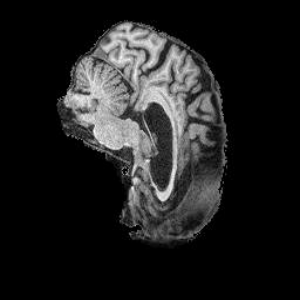

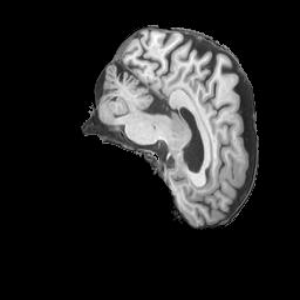

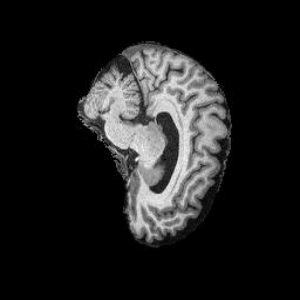

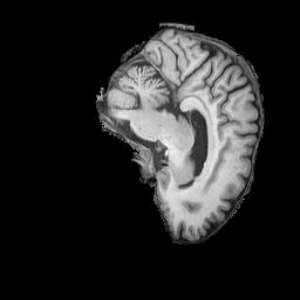

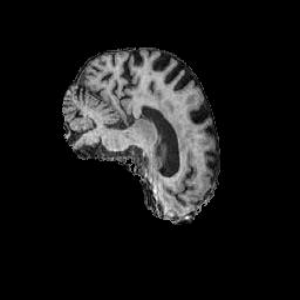

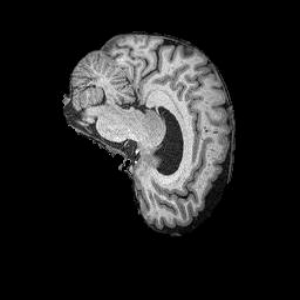

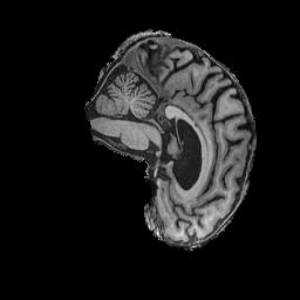

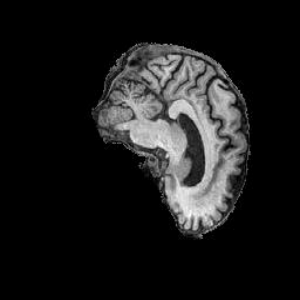

In [5]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

In [6]:
dataset = os.path.join(test_dir, "Combine")

test_img_paths = sorted(
    [
        os.path.join(dataset, fname)
        for fname in os.listdir(dataset)
        if fname.endswith(".jpeg")
    ]
)
# print(dataset)
# print(test_img_paths)

In [7]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# input1 = mpimg.imread(test_img_paths[0])
# print(input1.shape)
# input1 = input1 / 255.0
# im = tf.image.rgb_to_yuv(input1)
# print(im.shape,len(input1.shape))

In [8]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    print(input.shape)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    print(y.shape)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

(None, 300, 300, 3)
(None, 300, 300, 1)
(None, 300, 300, 3)
(None, 300, 300, 1)


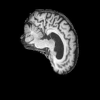

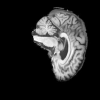

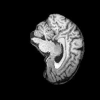

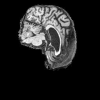

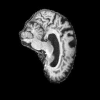

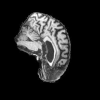

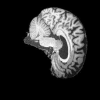

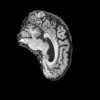

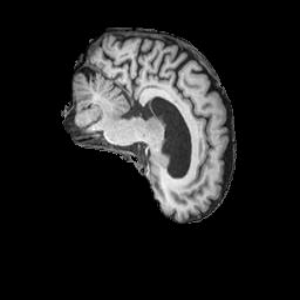

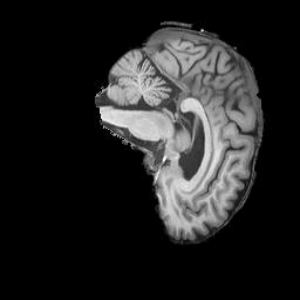

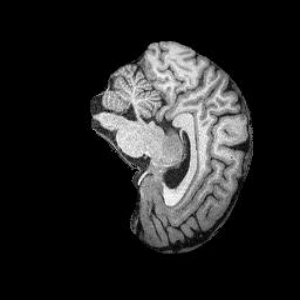

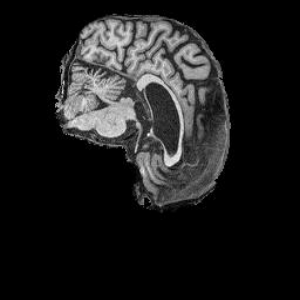

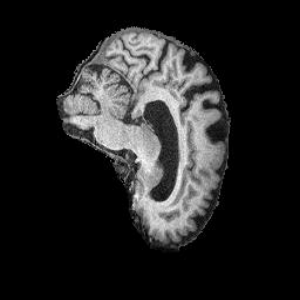

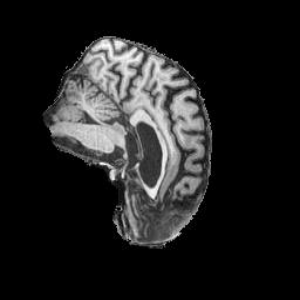

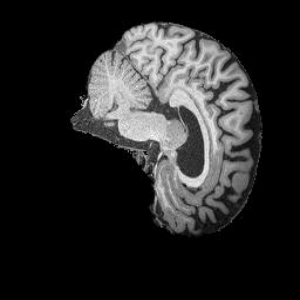

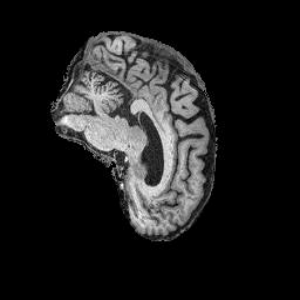

In [9]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [10]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 50, 100, 125, 175
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
#     plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


In [12]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


In [13]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

/tmp/ipykernel_10504/4276879471.py:41: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  PIL.Image.BICUBIC,


Epoch 1/100


2022-10-17 20:02:32.014139: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


Mean PSNR for epoch: 32.86
1/1 [==============================] - 0s 68ms/step


/tmp/ipykernel_10504/4276879471.py:62: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
/tmp/ipykernel_10504/4276879471.py:63: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)


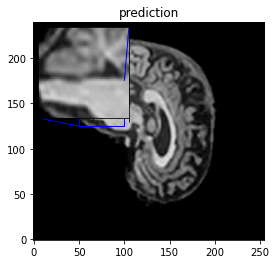

2152/2152 - 18s - loss: 7.6838e-04 - val_loss: 5.1633e-04 - 18s/epoch - 8ms/step
Epoch 2/100
Mean PSNR for epoch: 33.10
2152/2152 - 16s - loss: 5.0837e-04 - val_loss: 4.8838e-04 - 16s/epoch - 7ms/step
Epoch 3/100
Mean PSNR for epoch: 33.21
2152/2152 - 16s - loss: 4.8678e-04 - val_loss: 4.7542e-04 - 16s/epoch - 7ms/step
Epoch 4/100
Mean PSNR for epoch: 33.28
2152/2152 - 16s - loss: 4.7585e-04 - val_loss: 4.6814e-04 - 16s/epoch - 7ms/step
Epoch 5/100
Mean PSNR for epoch: 33.32
2152/2152 - 16s - loss: 4.6930e-04 - val_loss: 4.6426e-04 - 16s/epoch - 7ms/step
Epoch 6/100
Mean PSNR for epoch: 33.39
2152/2152 - 16s - loss: 4.6327e-04 - val_loss: 4.5736e-04 - 16s/epoch - 7ms/step
Epoch 7/100
Mean PSNR for epoch: 33.41
2152/2152 - 16s - loss: 4.5887e-04 - val_loss: 4.5561e-04 - 16s/epoch - 7ms/step
Epoch 8/100
Mean PSNR for epoch: 33.43
2152/2152 - 16s - loss: 4.5545e-04 - val_loss: 4.5181e-04 - 16s/epoch - 7ms/step
Epoch 9/100
Mean PSNR for epoch: 33.46
2152/2152 - 16s - loss: 4.5312e-04 - val

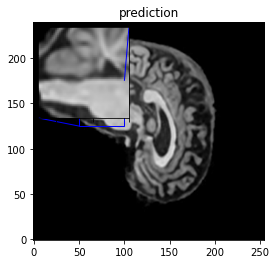

2152/2152 - 16s - loss: 4.3452e-04 - val_loss: 4.3176e-04 - 16s/epoch - 8ms/step
Epoch 22/100
Mean PSNR for epoch: 33.62
2152/2152 - 16s - loss: 4.3383e-04 - val_loss: 4.3386e-04 - 16s/epoch - 8ms/step
Epoch 23/100
Mean PSNR for epoch: 33.65
2152/2152 - 16s - loss: 4.3297e-04 - val_loss: 4.3024e-04 - 16s/epoch - 8ms/step
Epoch 24/100
Mean PSNR for epoch: 33.61
2152/2152 - 16s - loss: 4.3254e-04 - val_loss: 4.3485e-04 - 16s/epoch - 7ms/step
Epoch 25/100
Mean PSNR for epoch: 33.65
2152/2152 - 16s - loss: 4.3198e-04 - val_loss: 4.3087e-04 - 16s/epoch - 8ms/step
Epoch 26/100
Mean PSNR for epoch: 33.67
2152/2152 - 16s - loss: 4.3140e-04 - val_loss: 4.2946e-04 - 16s/epoch - 7ms/step
Epoch 27/100
Mean PSNR for epoch: 33.67
2152/2152 - 16s - loss: 4.3099e-04 - val_loss: 4.2806e-04 - 16s/epoch - 7ms/step
Epoch 28/100
Mean PSNR for epoch: 33.67
2152/2152 - 16s - loss: 4.3034e-04 - val_loss: 4.2817e-04 - 16s/epoch - 7ms/step
Epoch 29/100
Mean PSNR for epoch: 33.68
2152/2152 - 16s - loss: 4.2979e-

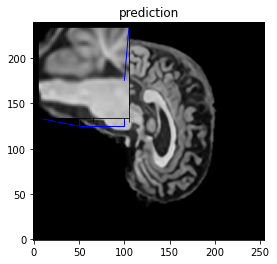

2152/2152 - 16s - loss: 4.2492e-04 - val_loss: 4.2352e-04 - 16s/epoch - 7ms/step
Epoch 42/100
Mean PSNR for epoch: 33.73
2152/2152 - 16s - loss: 4.2465e-04 - val_loss: 4.2314e-04 - 16s/epoch - 7ms/step
Epoch 43/100
Mean PSNR for epoch: 33.73
2152/2152 - 16s - loss: 4.2465e-04 - val_loss: 4.2249e-04 - 16s/epoch - 7ms/step
Epoch 44/100
Mean PSNR for epoch: 33.73
2152/2152 - 16s - loss: 4.2405e-04 - val_loss: 4.2292e-04 - 16s/epoch - 7ms/step
Epoch 45/100
Mean PSNR for epoch: 33.72
2152/2152 - 16s - loss: 4.2382e-04 - val_loss: 4.2345e-04 - 16s/epoch - 7ms/step
Epoch 46/100
Mean PSNR for epoch: 33.73
2152/2152 - 16s - loss: 4.2370e-04 - val_loss: 4.2302e-04 - 16s/epoch - 7ms/step
Epoch 47/100
Mean PSNR for epoch: 33.74
2152/2152 - 16s - loss: 4.2336e-04 - val_loss: 4.2241e-04 - 16s/epoch - 7ms/step
Epoch 48/100
Mean PSNR for epoch: 33.73
2152/2152 - 16s - loss: 4.2312e-04 - val_loss: 4.2307e-04 - 16s/epoch - 7ms/step
Epoch 49/100
Mean PSNR for epoch: 33.73
2152/2152 - 16s - loss: 4.2305e-

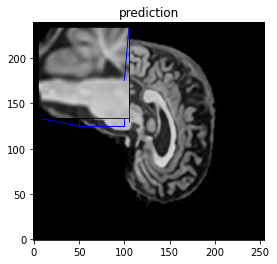

2152/2152 - 16s - loss: 4.2085e-04 - val_loss: 4.1970e-04 - 16s/epoch - 7ms/step
Epoch 62/100
Mean PSNR for epoch: 33.77
2152/2152 - 16s - loss: 4.2066e-04 - val_loss: 4.1912e-04 - 16s/epoch - 7ms/step
Epoch 63/100
Mean PSNR for epoch: 33.75
2152/2152 - 16s - loss: 4.2049e-04 - val_loss: 4.2090e-04 - 16s/epoch - 7ms/step
Epoch 64/100
Mean PSNR for epoch: 33.74
2152/2152 - 16s - loss: 4.2041e-04 - val_loss: 4.2154e-04 - 16s/epoch - 7ms/step
Epoch 65/100
Mean PSNR for epoch: 33.77
2152/2152 - 16s - loss: 4.2021e-04 - val_loss: 4.1918e-04 - 16s/epoch - 7ms/step
Epoch 66/100
Mean PSNR for epoch: 33.77
2152/2152 - 16s - loss: 4.2004e-04 - val_loss: 4.1852e-04 - 16s/epoch - 7ms/step
Epoch 67/100
Mean PSNR for epoch: 33.76
2152/2152 - 16s - loss: 4.1987e-04 - val_loss: 4.1936e-04 - 16s/epoch - 7ms/step
Epoch 68/100
Mean PSNR for epoch: 33.76
2152/2152 - 16s - loss: 4.1971e-04 - val_loss: 4.1957e-04 - 16s/epoch - 7ms/step
Epoch 69/100
Mean PSNR for epoch: 33.78
2152/2152 - 16s - loss: 4.1965e-

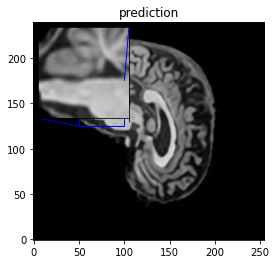

2152/2152 - 16s - loss: 4.1811e-04 - val_loss: 4.1621e-04 - 16s/epoch - 7ms/step
Epoch 82/100
Mean PSNR for epoch: 33.79
2152/2152 - 16s - loss: 4.1806e-04 - val_loss: 4.1680e-04 - 16s/epoch - 7ms/step
Epoch 83/100
Mean PSNR for epoch: 33.79
2152/2152 - 16s - loss: 4.1786e-04 - val_loss: 4.1686e-04 - 16s/epoch - 7ms/step
Epoch 84/100
Mean PSNR for epoch: 33.79
2152/2152 - 16s - loss: 4.1823e-04 - val_loss: 4.1700e-04 - 16s/epoch - 7ms/step
Epoch 85/100
Mean PSNR for epoch: 33.79
2152/2152 - 16s - loss: 4.1745e-04 - val_loss: 4.1679e-04 - 16s/epoch - 7ms/step
Epoch 86/100
Mean PSNR for epoch: 33.80
2152/2152 - 16s - loss: 4.1756e-04 - val_loss: 4.1631e-04 - 16s/epoch - 7ms/step
Epoch 87/100
Mean PSNR for epoch: 33.79
2152/2152 - 16s - loss: 4.1755e-04 - val_loss: 4.1676e-04 - 16s/epoch - 7ms/step
Epoch 88/100
Mean PSNR for epoch: 33.79
2152/2152 - 16s - loss: 4.1749e-04 - val_loss: 4.1705e-04 - 16s/epoch - 7ms/step
Epoch 89/100
Mean PSNR for epoch: 33.80
2152/2152 - 16s - loss: 4.1732e-

In [14]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)


1/1 [==============================] - 0s 11ms/step
PSNR of low resolution image and high resolution image is 27.7257
PSNR of predict and high resolution is 30.0253


/tmp/ipykernel_10504/4276879471.py:41: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  PIL.Image.BICUBIC,
/tmp/ipykernel_10504/4276879471.py:62: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
/tmp/ipykernel_10504/4276879471.py:63: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)


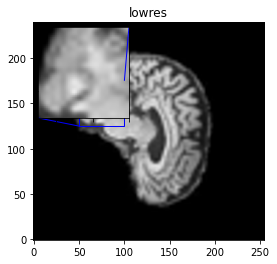

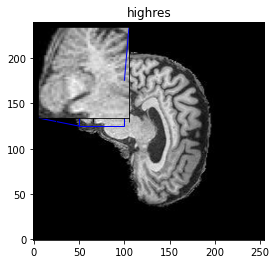

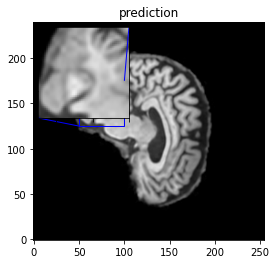

1/1 [==============================] - 0s 11ms/step
PSNR of low resolution image and high resolution image is 28.2935
PSNR of predict and high resolution is 30.6139


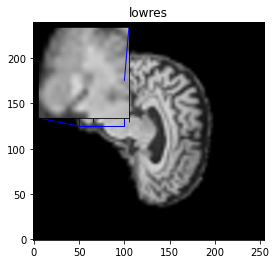

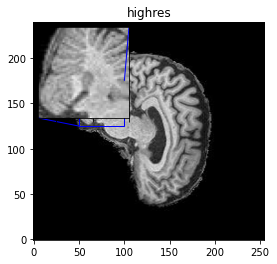

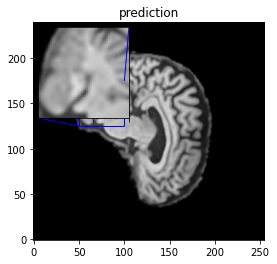

1/1 [==============================] - 0s 10ms/step
PSNR of low resolution image and high resolution image is 27.6166
PSNR of predict and high resolution is 29.8033


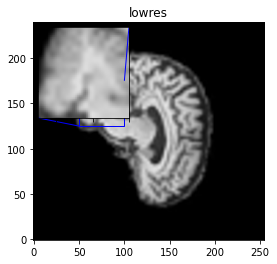

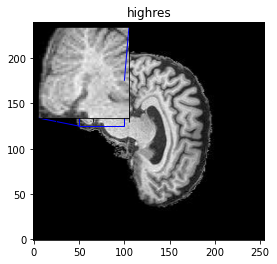

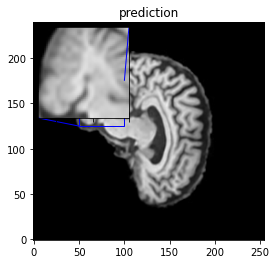

1/1 [==============================] - 0s 11ms/step
PSNR of low resolution image and high resolution image is 27.7023
PSNR of predict and high resolution is 29.8075


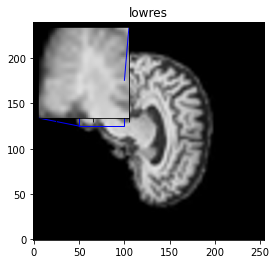

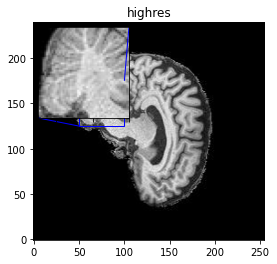

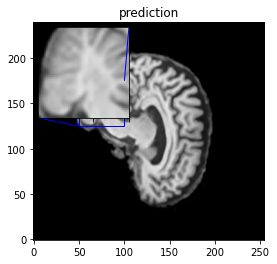

1/1 [==============================] - 0s 11ms/step
PSNR of low resolution image and high resolution image is 27.7613
PSNR of predict and high resolution is 29.7331


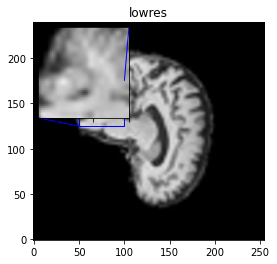

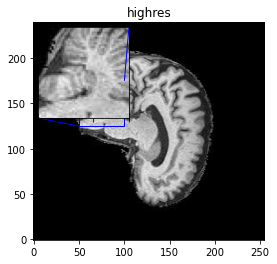

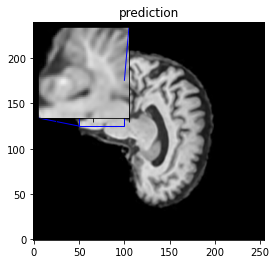

1/1 [==============================] - 0s 10ms/step
PSNR of low resolution image and high resolution image is 27.9223
PSNR of predict and high resolution is 29.8955


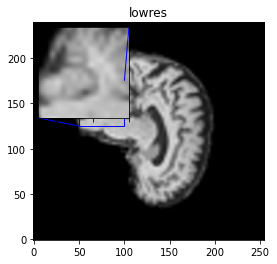

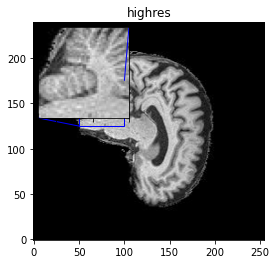

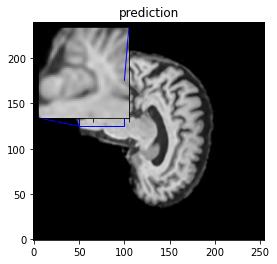

1/1 [==============================] - 0s 10ms/step
PSNR of low resolution image and high resolution image is 27.7062
PSNR of predict and high resolution is 29.6346


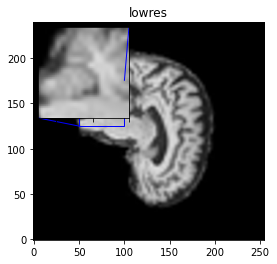

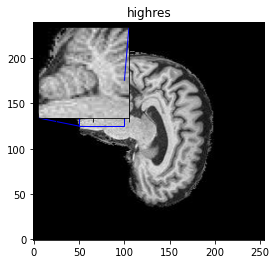

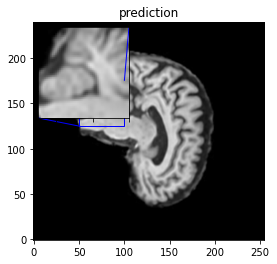

1/1 [==============================] - 0s 10ms/step
PSNR of low resolution image and high resolution image is 27.7445
PSNR of predict and high resolution is 29.8125


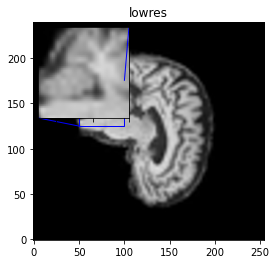

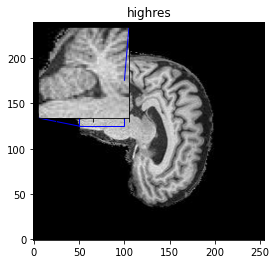

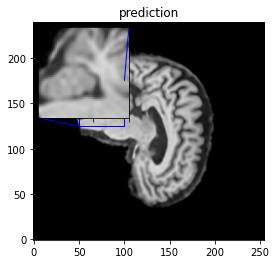

1/1 [==============================] - 0s 11ms/step
PSNR of low resolution image and high resolution image is 27.4116
PSNR of predict and high resolution is 29.5505


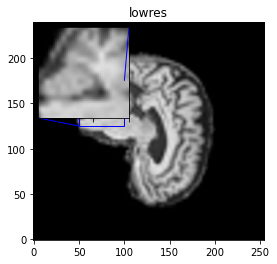

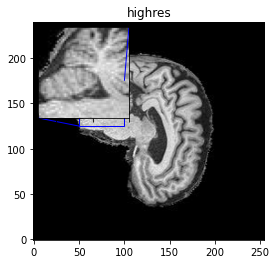

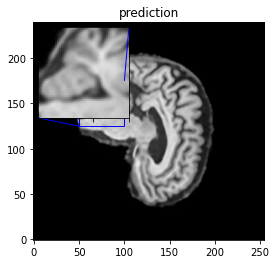

1/1 [==============================] - 0s 10ms/step
PSNR of low resolution image and high resolution image is 27.5510
PSNR of predict and high resolution is 29.5950


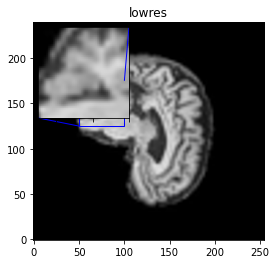

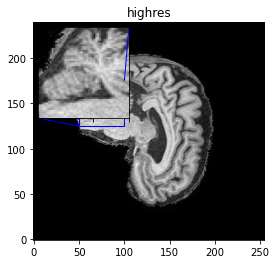

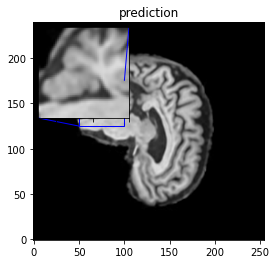

Avg. PSNR of lowres images is 27.7435
Avg. PSNR of reconstructions is 29.8471


In [15]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))


In [2]:
from ipynb.fs.full.Untitled import *
testing = factorial(5)
testing

120